In [1]:
## Automl with ersilia embeddings
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, classification_report
import flaml
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
# Load the model
model_path = '../../checkpoints/AutoML_ersilia.joblib'
AutoML_model = joblib.load(model_path)

In [4]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [7]:
##Convert SMILES to Ersilia Embeddings:

from eosce.models import ErsiliaCompoundEmbeddings

# Assuming 'SMILES' is the column containing chemical compounds in your TDC dataset
tdc_compounds = tdc_data['Drug'].tolist()

# Initialize the ErsiliaCompoundEmbeddings model
model = ErsiliaCompoundEmbeddings()

# Create a new column for embeddings
tdc_data['embeddings'] = tdc_data['Drug'].apply(lambda x: model.transform([x])[0])


# Assuming preprocess_data is your data preprocessing function
X_tdc = tdc_data['embeddings']

In [13]:
print(X_tdc)

[[ 0.05109995 -0.03427058 -0.04409432 ... -0.09193674 -0.09690802
  -0.1369709 ]
 [-0.04658331 -0.04430011  0.06653848 ...  0.06754929  0.03870305
  -0.02559676]
 [-0.02224451 -0.04971424  0.00392899 ... -0.13136318 -0.01966518
  -0.15767808]
 ...
 [ 0.10620239 -0.00728114 -0.25737908 ...  0.2572299  -0.14715151
  -0.07315046]
 [ 0.03251487  0.02081342  0.00105103 ...  0.0214402   0.0128008
   0.04853983]
 [ 0.09114363 -0.00090368 -0.22689229 ...  0.24736543 -0.17306463
  -0.07271356]]


In [12]:
X_tdc = np.array(tdc_data['embeddings'].tolist())

AUC on TDC dataset: 0.8267436267436267


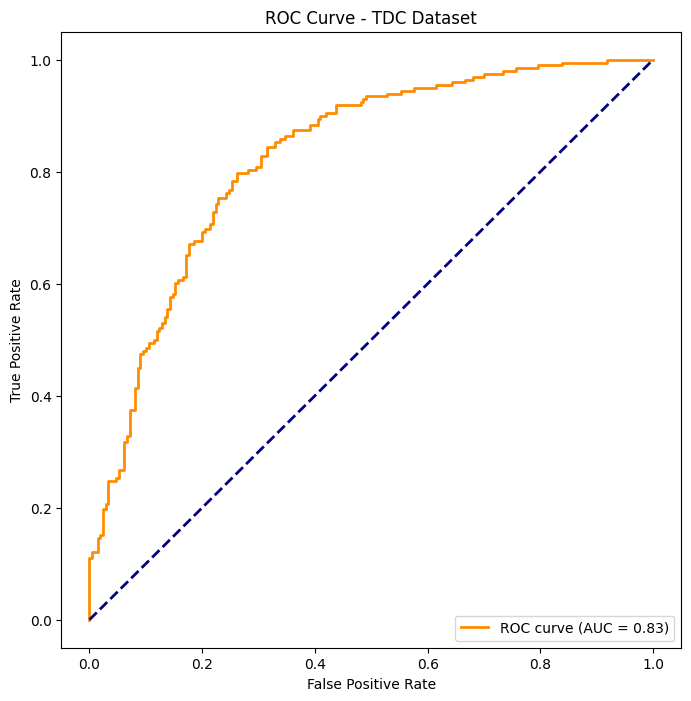

In [17]:
# Predict probabilities for the positive class
tdc_predictions_proba = AutoML_model.predict_proba(X_tdc)[:, 1]

# Assuming you have the true labels in 'Target' column
# Calculate ROC curve and AUC
fpr_tdc, tpr_tdc, thresholds_tdc = roc_curve(tdc_data['Y'], tdc_predictions_proba)
auc_tdc = auc(fpr_tdc, tpr_tdc)

print(f"AUC on TDC dataset: {auc_tdc}")

# Optionally, visualize the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr_tdc, tpr_tdc, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_tdc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TDC Dataset')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate classification report
classification_rep = classification_report(true_labels, tdc_predictions)

# Print the classification report
print("Classification Report on TDC dataset:")
print(classification_rep)

Classification Report on TDC dataset:
              precision    recall  f1-score   support

         0.0       0.92      0.29      0.44       210
         1.0       0.56      0.97      0.71       198

    accuracy                           0.62       408
   macro avg       0.74      0.63      0.57       408
weighted avg       0.75      0.62      0.57       408



In [19]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, tdc_predictions)

# Print the confusion matrix
print("Confusion Matrix on TDC dataset:")
print(conf_matrix)


Confusion Matrix on TDC dataset:
[[ 60 150]
 [  5 193]]


In [ ]:
## AutoML with morgan fingerprints

In [48]:
# Load the model
model_path = '../../checkpoints/AutoML_morgan_fp.joblib'
AutoML_model = joblib.load(model_path)

In [49]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [50]:
# Add RDKit Molecules Column and Filter out Invalid Molecules
tdc_data['mol'] = tdc_data['Drug'].apply(lambda x: Chem.MolFromSmiles(x) if x is not None else None)
tdc_data = tdc_data.dropna(subset=['mol'])

# Generate Morgan Fingerprints
tdc_data['morgan_fps'] = tdc_data['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

In [51]:
# Prepare Data for Model Input
max_length = max(len(fp.GetOnBits()) for fp in tdc_data['morgan_fps'])
X_tdc = np.array([list(fp.GetOnBits()) + [0] * (max_length - len(fp.GetOnBits())) for fp in tdc_data['morgan_fps']])

In [52]:
# Assuming X_tdc is your TDC dataset with 95 features
X_tdc = np.hstack([X_tdc, np.zeros((X_tdc.shape[0], 123 - 95))])

In [53]:
X_tdc.shape

(408, 123)

In [54]:
y_tdc = tdc_data['Y']

AUC on TDC dataset: 0.6221861471861472


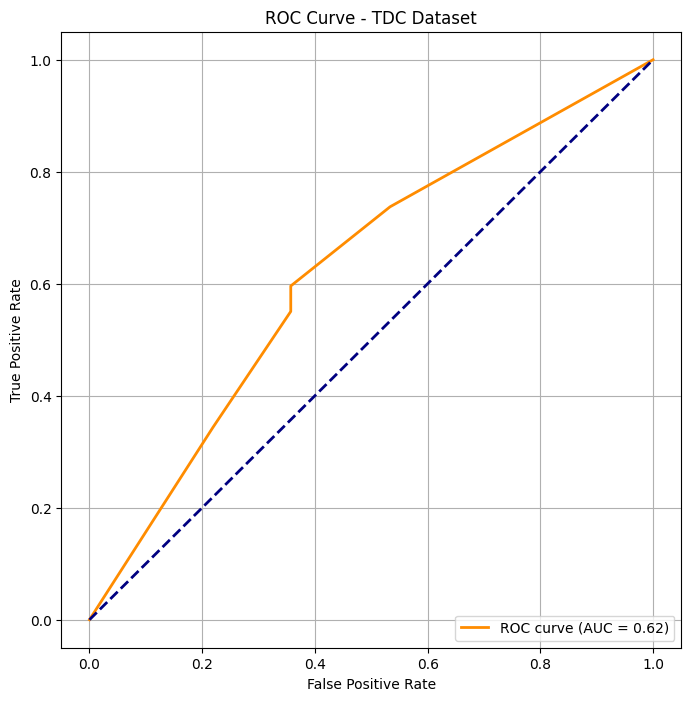

In [55]:
# Predict probabilities for the positive class
tdc_predictions_proba = AutoML_model.predict_proba(X_tdc)[:, 1]

# Calculate ROC curve and AUC
fpr_tdc, tpr_tdc, thresholds_tdc = roc_curve(y_tdc, tdc_predictions_proba)
auc_tdc = auc(fpr_tdc, tpr_tdc)

print(f"AUC on TDC dataset: {auc_tdc}")

#  visualize the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr_tdc, tpr_tdc, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_tdc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TDC Dataset')
plt.legend(loc="lower right")
plt.grid(True)  
plt.show()

In [56]:
from sklearn.metrics import classification_report

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate classification report
classification_rep = classification_report(true_labels, tdc_predictions)

# Print the classification report
print("Classification Report on TDC dataset:")
print(classification_rep)

Classification Report on TDC dataset:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       210
         1.0       0.49      1.00      0.65       198

    accuracy                           0.49       408
   macro avg       0.24      0.50      0.33       408
weighted avg       0.24      0.49      0.32       408



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [57]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, tdc_predictions)

# Print the confusion matrix
print("Confusion Matrix on TDC dataset:")
print(conf_matrix)


Confusion Matrix on TDC dataset:
[[  0 210]
 [  0 198]]


In [ ]:
## Autogluon with Morgan fingerprints

In [8]:
# Load the model
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor.load("AutogluonModels/ag-20240116_002025")

In [7]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [9]:
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles

tdc_data['mol'] = tdc_data['Drug'].apply(lambda x: MolFromSmiles(x))
tdc_data['morgan_fp'] = tdc_data['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
tdc_data['morgan_vec'] = [list(fp.ToBitString()) for fp in tdc_data['morgan_fp']]
tdc_X_flattened = pd.DataFrame(tdc_data['morgan_vec'].tolist()).apply(lambda x: x.explode()).reset_index(drop=True)

In [11]:
# Make predictions on the TDC dataset
tdc_predictions = predictor.predict(tdc_X_flattened)

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


tdc_true_labels = tdc_data['Y']

# Calculate predictions
tdc_predictions = predictor.predict(tdc_X_flattened)

# Evaluate performance
accuracy = accuracy_score(tdc_true_labels, tdc_predictions)
classification_report_str = classification_report(tdc_true_labels, tdc_predictions)
confusion_mat = confusion_matrix(tdc_true_labels, tdc_predictions)

# Print or use the metrics as needed
print(f"Accuracy on TDC dataset: {accuracy}")
print("Classification Report:\n", classification_report_str)
print("Confusion Matrix:\n", confusion_mat)


Accuracy on TDC dataset: 0.7034313725490197
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.49      0.63       210
         1.0       0.63      0.93      0.75       198

    accuracy                           0.70       408
   macro avg       0.76      0.71      0.69       408
weighted avg       0.76      0.70      0.69       408

Confusion Matrix:
 [[103 107]
 [ 14 184]]


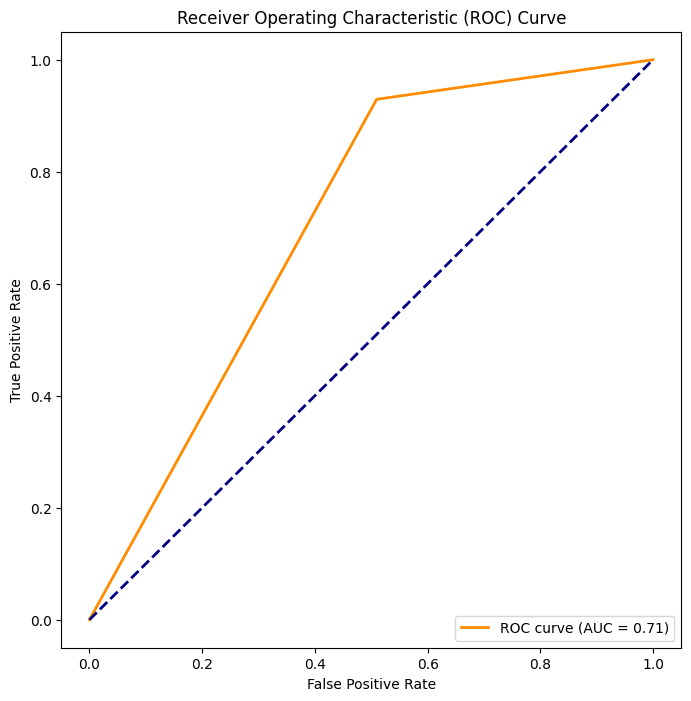

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'outcome' is the name of the Series containing predicted outcomes
tdc_predictions = tdc_predictions

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(tdc_true_labels, tdc_predictions)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(tdc_true_labels, tdc_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


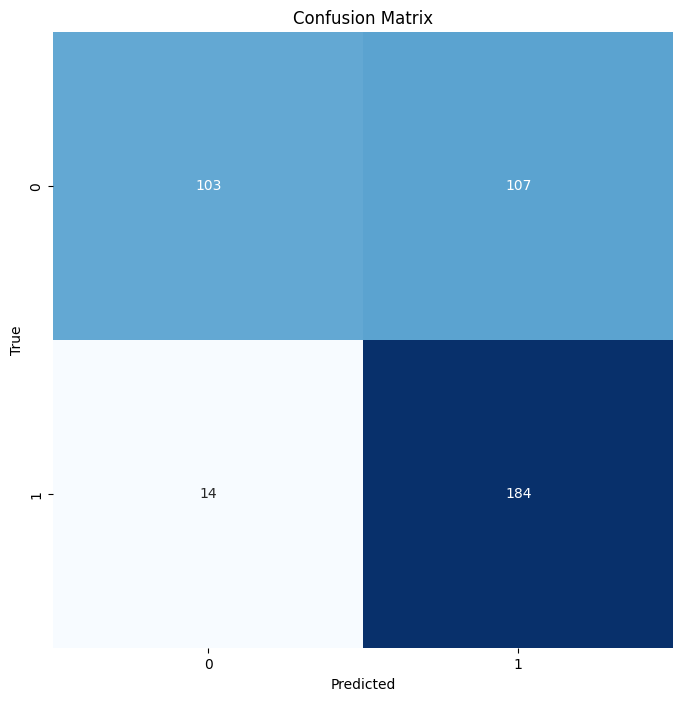

In [27]:
##Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'outcome' is the name of the Series containing predicted outcomes
tdc_predictions = tdc_predictions

# Calculate confusion matrix
cm = confusion_matrix(tdc_true_labels, tdc_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
## Autogluon with ersilia embeddings

In [28]:
# Load the model
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor.load("AutogluonModels/ag-20240116_004526")

In [29]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [30]:
tdc_compounds = tdc_data['Drug'].tolist()

In [32]:
# Initialize the ErsiliaCompoundEmbeddings model
from eosce.models import ErsiliaCompoundEmbeddings
model = ErsiliaCompoundEmbeddings()

In [33]:
# Transform SMILES strings to embeddings using the trained ErsiliaCompoundEmbeddings model
tdc_embeddings = [model.transform([smiles])[0] for smiles in tdc_compounds]

In [35]:
# Convert embeddings to a flat list
tdc_embeddings_list = [embedding.flatten().tolist() for embedding in tdc_embeddings]

# Convert the list to a tuple
tdc_tuples = [tuple(embedding) for embedding in tdc_embeddings_list]

# Create a DataFrame for TDC dataset
df_tdc = pd.DataFrame({'embeddings': tdc_tuples})

In [36]:
# Make predictions using the trained Autogluon model
tdc_predictions = predictor.predict(df_tdc)

In [40]:
from sklearn.metrics import classification_report


tdc_labels = tdc_data['Y'].tolist()  

# Create a DataFrame with labels and predictions
df_tdc_results = pd.DataFrame({'outcome': tdc_labels, 'prediction': tdc_predictions, 'embeddings': tdc_tuples})

# Display the classification report
classification_rep = classification_report(df_tdc_results['outcome'], df_tdc_results['prediction'])
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       210
         1.0       0.49      1.00      0.65       198

    accuracy                           0.49       408
   macro avg       0.74      0.50      0.33       408
weighted avg       0.75      0.49      0.32       408



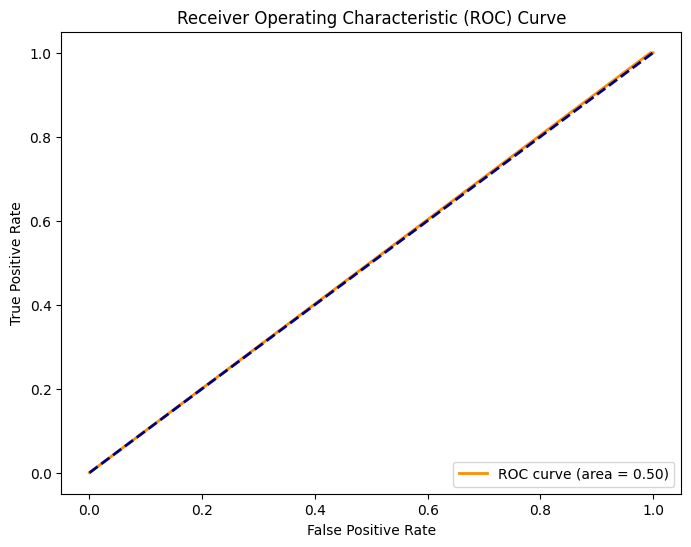

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'Outcome' is the column containing ground truth labels in your TDC dataset
tdc_labels = tdc_data['Y']
# Assuming 'prediction' is the column containing model predictions
tdc_predictions = df_tdc_results['prediction']

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(tdc_labels, tdc_predictions)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
